In [46]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import copy
from skimage.transform import resize
from prepare_data import get_anns

In [2]:

from scipy.io import loadmat
import cv2
from typing import List, Tuple

In [3]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
# from model import CSRNet
import torch
import scipy.spatial
%matplotlib inline
from skimage.transform import resize

In [4]:
def _resize(image, matrix):

    im = Image.open(image)
    w, h = im.size
    im = im.resize((224,224))
    new_pts = np.zeros(matrix.shape)
    for i, pt in enumerate(matrix):
        new_pts[i][0] = pt[0]*(224/w)
        new_pts[i][1] = pt[1]*(224/h)
    
    return im , new_pts

In [13]:
img_path = '/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/NWPU-Crowd-Sample-Code/NWPU-Crowd/images/*.jpg'
mat_path = '/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/NWPU-Crowd/mats/*.mat'
images = {}
mats = {}

for name in glob.glob(img_path):
    key = int(name.replace('/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/NWPU-Crowd-Sample-Code/NWPU-Crowd/images/','').replace('.jpg',''))
    images[key] = name

for name in glob.glob(mat_path):
    key = int(name.replace('/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/NWPU-Crowd/mats/','').replace('.mat',''))
    mats[key] = name

images = dict(sorted(images.items()))
mats = dict(sorted(mats.items()))


In [50]:
def get_points(path):
    with open(path,'r') as f:
        data = json.load(f)
    return data['points']

In [ ]:
anns = get_anns()

In [ ]:
for key in anns:
    try:
        im_path = f"/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/NWPU-Crowd-Sample-Code/NWPU-Crowd/images/{str(key)}.jpg"
        img = plt.imread(im_path)
    except:
        print('except for', im_path)
        continue
    json_path = f"/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/NWPU-Crowd/jsons/{str(key)}.json"
    print(json_path)
    m = np.asarray(get_points(json_path))
    
    
    imag, gt = _resize(im_path, m)
    k = np.zeros((imag.size[1],imag.size[0]))
    # print(len(gt))
    for i in range(0,len(gt)):
        # print(i)
        if int(gt[i][1])<imag.size[1] and int(gt[i][0])<imag.size[0]:
            k[int(gt[i][1]),int(gt[i][0])] = 100
    try:
        k = gaussian_filter(k, sigma=(1, 1), order=0)
    except:
        print('except for', im_path)
        continue
    with h5py.File('NWPU_density/'+im_path.replace('/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/NWPU-Crowd-Sample-Code/NWPU-Crowd/images/','').replace('.jpg','')+'.h5', 'w') as hf:
            hf['density'] = k

In [56]:
def get_count(path):
    with open(path,'r') as f:
        data = json.load(f)
    return data['human_num']

In [59]:
get_count(json_path)

163

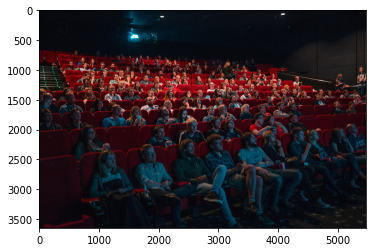

In [55]:
img = plt.imread(im_path)
plt.imshow(img)

(224, 224)


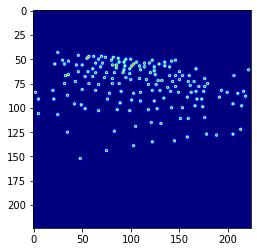

In [53]:
groundtruth = np.asarray(k)
print(groundtruth.shape)
plt.imshow(groundtruth,cmap=CM.jet)

In [54]:
np.sum(groundtruth/100)

163.0

In [33]:
mat = io.loadmat('/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/NWPU-Crowd/mats/1001.mat')
len(mat['annPoints'])

174

In [81]:
def get_density(h5):
    with h5py.File(h5,'r') as f:
        x = np.asarray(f['density'])
    return x

In [62]:
def create_hdf5(dataset_name: str,
                train_size: int,
                valid_size: int,
                img_size: Tuple[int, int],
                in_channels: int=3):
    """
    Create empty training and validation HDF5 files with placeholders
    for images and labels (density maps).

    Note:
    Datasets are saved in [dataset_name]/train.h5 and [dataset_name]/valid.h5.
    Existing files will be overwritten.

    Args:
        dataset_name: used to create a folder for train.h5 and valid.h5
        train_size: no. of training samples
        valid_size: no. of validation samples
        img_size: (width, height) of a single image / density map
        in_channels: no. of channels of an input image

    Returns:
        A tuple of pointers to training and validation HDF5 files.
    """
    # create output folder if it does not exist
    os.makedirs(dataset_name, exist_ok=True)

    # create HDF5 files: [dataset_name]/(train | valid).h5
    train_h5 = h5py.File(os.path.join(dataset_name, 'train.h5'), 'w')
    valid_h5 = h5py.File(os.path.join(dataset_name, 'valid.h5'), 'w')

    # add two HDF5 datasets (images and labels) for each HDF5 file
    for h5, size in ((train_h5, train_size), (valid_h5, valid_size)):
        h5.create_dataset('images', (size, in_channels, *img_size))
        h5.create_dataset('labels', (size, 1, *img_size))

    return train_h5, valid_h5

In [80]:
anns = get_anns()
train_anns = {key: anns[key] for key in anns.keys() if int(key)>=700}
valid_anns = {key: anns[key] for key in anns.keys() if int(key)<=700}
print(len(train_anns.keys()),len(valid_anns.keys()))

1683 402


In [94]:
def generate_nwpu_data():
    """Generate HDF5 files for nwpu dataset."""

    train_h5, valid_h5 = create_hdf5('NWPU_dataset',
                                     train_size=1683,
                                     valid_size=402,
                                     img_size=(224, 224),
                                     in_channels=3)

    # load labels infomation from provided MATLAB file
    # it is a numpy array with (x, y) objects position for subsequent frames

    def fill_h5(h5, anns, init_frame=0):
        """
        Save images and labels in given HDF5 file.

        Args:
            h5: HDF5 file
            labels: the list of labels
            init_frame: the first frame in given list of labels
        """
        for i, key in enumerate(anns.keys()):
            # path to the next frame (filename convention: seq_XXXXXX.jpg)
            img_path = f"/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/NWPU-Crowd-Sample-Code/NWPU-Crowd/images/{str(key)}.jpg"
            density_path = f"/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/objects_counting_dmap/NWPU_density/{str(key)}.h5"
            print(i)

            # get an image as numpy array
            try:
                image = np.array(Image.open(img_path).resize((224,224)), dtype=np.float32) / 255
            except:
                print('image not present',key,'.jpg')
                continue
            image = np.transpose(image, (2, 0, 1))
            if image.shape[0]==3:
                pass
            else:
                continue
            # generate a density map by applying a Gaussian filter
            try:
                label = get_density(density_path)
            except:
                print('density not present',key,'.h5')
                continue
            # save data to HDF5 file
            h5['images'][i - init_frame] = image
            h5['labels'][i - init_frame, 0] = label

    # use first 1500 frames for training and the last 500 for validation
    fill_h5(train_h5, train_anns)
    fill_h5(valid_h5, valid_anns, 1683)

    # close HDF5 file
    train_h5.close()
    valid_h5.close()

In [95]:
generate_nwpu_data()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
density not present 3448 .h5
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
density not present 1041 .h5
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262


In [66]:
with h5py.File('/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/objects_counting_dmap/NWPU_dataset/train.h5', 'r') as f:
    print(f.keys())
    print(type(f['images']))
    images = []
    labels = []
    for i in range(len(f['images'])):
        images.append(f['images'][i])
        labels.append(f['labels'][i])

<KeysViewHDF5 ['images', 'labels']>
<class 'h5py._hl.dataset.Dataset'>
